In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys, os
sys.path.append(os.path.join(os.path.dirname('__file__'), '..', 'Features'))
import world_constructions as WC

c:\Users\juand\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
c:\Users\juand\anaconda3\Lib\site-packages\transformers\utils\generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\juand\anaconda3\Lib\site-packages\transformers\utils\generic.py:339: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Loading data

In [3]:
df_lux = WC.world_construction.init_luxury_gallery()
df_ret = WC.world_construction.init_retail_gallery()    

In [4]:
df = pd.concat([df_lux,df_ret])

In [5]:
df.head(2)

,id,prod_id,Detail,Summary,Brand,Price,base64
0,4,4,Type: Shirt / Fit: Regular fit / Sleeve...,"The shirt from Gucci, as shown in the images, ...",Gucci,1300.0,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
1,2,2,Type: Shirt / Fit: Regular fit / Sleeve...,The showcased shirt is a Gucci Oxford cotton s...,Gucci,650.0,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."


In [6]:
df_base64 = df[['prod_id','base64']]

## Transoforming details into columns

In [7]:
final_df = pd.DataFrame()

for parent_row in df.Detail: 
    x = []
    for row in parent_row.split('/'):
        x.append(row.split(':'))

    temp_dataframe = pd.DataFrame(x)
    temp_dataframe[0] = temp_dataframe[0].str.lower()
    temp_dataframe = temp_dataframe.sort_values(by=0)
    temp_dataframe = temp_dataframe.groupby(0)[1].apply(lambda x: ', '.join(x)).reset_index()
        
    temp_dataframe = temp_dataframe.set_index(0).T
    temp_dataframe.columns = temp_dataframe.columns.str.lstrip()
    
    final_df = pd.concat([final_df,temp_dataframe], ignore_index = True)

final_df['seasson'] = final_df['season'].combine_first(final_df['seasson'])
final_df = final_df.drop('season', axis=1)

In [8]:
mask_duplicates = final_df.duplicated()

In [9]:
final_df['prod_id'] = df['prod_id'].values

In [10]:
final_df.head(1)

,breathability,collar style,colors,details and embellishments,fabric weight,fit,fluidity of fabric,formality,lapel,length,...,pocket placement,pocket presence,pocket size,shape,sleeve style,texture,transparency,type,seasson,prod_id
0,High,Button-down,"60% White, 20% Red, 20% Green",Buttons,Light,Regular fit,High,Business Casual,Not applicable,Hip-length,...,Not applicable,No,Not applicable,Fitted,Long sleeve,Smooth,Opaque,Shirt,"Spring, Summer, Autumn",4


In [11]:
print(df.shape)
print(final_df.shape)

(154, 7)
(154, 25)


In [12]:
df_images = df[['prod_id','base64']]

In [13]:
df.drop(['Detail','id','base64'],axis=1,inplace=True)

In [14]:
df = pd.merge(df,final_df,on='prod_id')

In [15]:
df.head(1)

,prod_id,Summary,Brand,Price,breathability,collar style,colors,details and embellishments,fabric weight,fit,...,patterns placement,pocket placement,pocket presence,pocket size,shape,sleeve style,texture,transparency,type,seasson
0,4,"The shirt from Gucci, as shown in the images, ...",Gucci,1300.0,High,Button-down,"60% White, 20% Red, 20% Green",Buttons,Light,Regular fit,...,Throughout,Not applicable,No,Not applicable,Fitted,Long sleeve,Smooth,Opaque,Shirt,"Spring, Summer, Autumn"


In [16]:
df[mask_duplicates]

,prod_id,Summary,Brand,Price,breathability,collar style,colors,details and embellishments,fabric weight,fit,...,patterns placement,pocket placement,pocket presence,pocket size,shape,sleeve style,texture,transparency,type,seasson
109,110,"The top showcased in the images is a black, fl...",Mango,29.99,Medium,Crew neck,100% Black,Not applicable,Medium,Regular fit,...,Not applicable,Not applicable,No,Not applicable,Fitted,Long sleeve,Smooth,Opaque,Top - Shirt,"Autumn, Winter"
136,36,The top showcased in the images is a stylish a...,HM,9.99,High,Crew neck,White (100%),Not applicable,Light,Regular fit,...,Not applicable,Not applicable,No,Not applicable,Fitted,Long sleeve,Smooth,Opaque,"Top, Shirt","Spring, Summer"
137,43,The top showcased in the images is a classic s...,HM,25.99,High,Crew neck,White (100%),Not applicable,Light,Regular fit,...,Not applicable,Not applicable,No,Not applicable,Fitted,Long sleeve,Smooth,Opaque,"Top, Shirt","Spring, Summer, Autumn"


#### Summary transformation

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

In [18]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     c:\Users\juand\anaconda3\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     c:\Users\juand\anaconda3\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
# Lowercase the descriptions
df['Summary_treated'] = df['Summary'].str.lower()

# Remove punctuation
df['Summary_treated'] = df['Summary_treated'].str.translate(str.maketrans('', '', string.punctuation))

# Remove stop words
stop = set(stopwords.words('english'))
df['Summary_treated'] = df['Summary_treated'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

# Lemmatize the words
lemmatizer = WordNetLemmatizer()
df['Summary_treated'] = df['Summary_treated'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [20]:
df[['Summary','Summary_treated']].head()

,Summary,Summary_treated
0,"The shirt from Gucci, as shown in the images, ...",shirt gucci shown image silk piece inspired su...
1,The showcased shirt is a Gucci Oxford cotton s...,showcased shirt gucci oxford cotton shirt gg s...
2,The top showcased in the images is a Gucci flo...,top showcased image gucci floral lace top feat...
3,The shirt shown in the images is a light beige...,shirt shown image light beige camicia gabardin...
4,The showcased shirt is a Gucci poplin cotton t...,showcased shirt gucci poplin cotton top inspir...


## NLP on summary


#### word freq

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the descriptions
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit(df['Summary_treated'])

In [22]:
df.Brand.unique()

array(['Gucci', 'Prada', 'HM', 'Mango'], dtype=object)

In [23]:
# Example: Check for common words in luxury vs retail brands
luxury_brands = ['Gucci', 'Prada']  # Add your luxury brands here
retail_brands = ['HM', 'Mango']  # Add your retail brands here

luxury_desc = df[df['Brand'].isin(luxury_brands)]['Summary_treated']
retail_desc = df[df['Brand'].isin(retail_brands)]['Summary_treated']

In [24]:
# Create a vectorized function to remove "sleeve"
def remove_sleeve(sentence):
    sentence = sentence.replace('feature', '')
    sentence = sentence.replace('shirt', '')
    sentence = sentence.replace('suitable', '')
    sentence = sentence.replace('making', '')
    sentence = sentence.replace('fabric', '')
    sentence = sentence.replace('occasion', '')
    sentence = sentence.replace('look', '')
    sentence = sentence.replace('ensuring', '')
    sentence = sentence.replace('style', '')
    sentence = sentence.replace('showcased', '')
    sentence = sentence.replace('adding', '')
    sentence = sentence.replace('visible', '')
    sentence = sentence.replace('ideal', '')
    sentence = sentence.replace('standard', '')
    sentence = sentence.replace('image', '')
    sentence = sentence.replace('sleeve', '')
    sentence = sentence.replace('long', '')
    sentence = sentence.replace('collar', '')
    sentence = sentence.replace('color', '')
    sentence = sentence.replace('material', '')
    sentence = sentence.replace('gucci', '')
    sentence = sentence.replace('season', '')
    sentence = sentence.replace('fit', '')
    sentence = sentence.replace('summer', '')
    sentence = sentence.replace('spring', '')
    sentence = sentence.replace('touch', '')
    sentence = sentence.replace('appears', '')
    sentence = sentence.replace('enhancing', '')
    sentence = sentence.replace('length', '')

    return sentence

In [25]:
def create_common_Words(df):

    luxury_brands = ['Gucci', 'Prada']  # Add your luxury brands here
    retail_brands = ['HM', 'Mango']  # Add your retail brands here

    luxury_desc = df[df['Brand'].isin(luxury_brands)]['Summary_treated']
    retail_desc = df[df['Brand'].isin(retail_brands)]['Summary_treated']

    # Apply the function to the array
    luxury_desc = np.vectorize(remove_sleeve)(luxury_desc)
    retail_desc = np.vectorize(remove_sleeve)(retail_desc)

    luxury_words = vectorizer.transform(luxury_desc)
    retail_words = vectorizer.transform(retail_desc)


    luxury_words_df = pd.DataFrame(luxury_words.toarray(), columns=vectorizer.get_feature_names_out())
    retail_words_df = pd.DataFrame(retail_words.toarray(), columns=vectorizer.get_feature_names_out())


    # Most common words in luxury vs retail
    luxury_common_words = luxury_words_df.sum().sort_values(ascending=False).head(20)
    retail_common_words = retail_words_df.sum().sort_values(ascending=False).head(20)


    plt.figure(figsize=(10, 6))
    sns.barplot(x=luxury_common_words.values, y=luxury_common_words.index, palette='viridis')
    plt.title('Top 20 Words in Luxury Descriptions')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=retail_common_words.values, y=retail_common_words.index, palette='viridis')
    plt.title('Top 20 Words in Retail Descriptions')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()


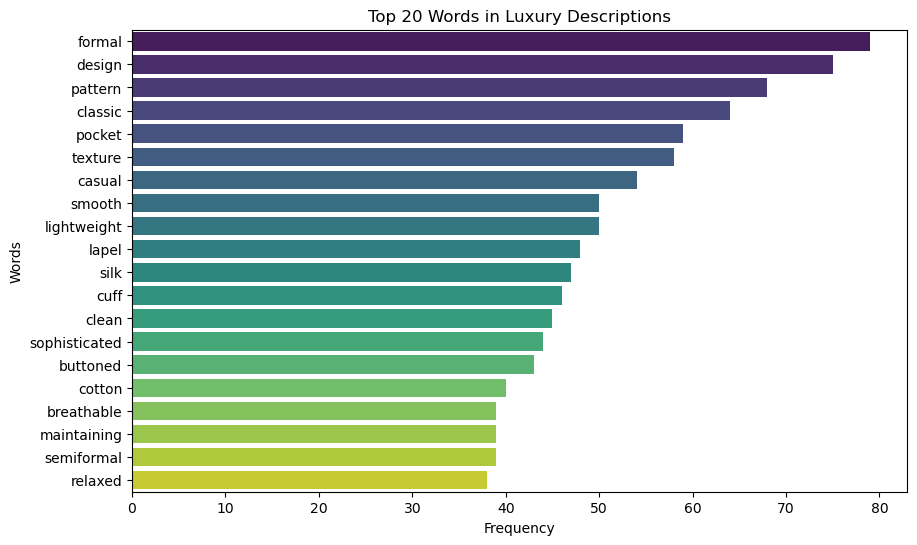

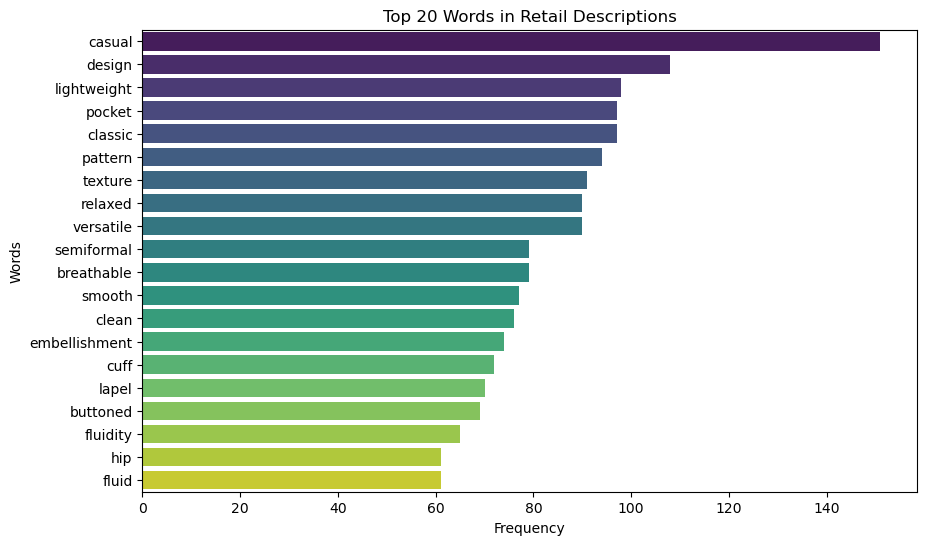

In [26]:
create_common_Words(df=df)

#### Clustering
- Hierarchical clustering heatmap
- array of cosine distances luxury vs retail
- dendogramas son con structure

In [27]:
from sentence_transformers import SentenceTransformer

In [28]:
# Step 2: Load the model
model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name)

In [29]:
df.head(1)

,prod_id,Summary,Brand,Price,breathability,collar style,colors,details and embellishments,fabric weight,fit,...,pocket placement,pocket presence,pocket size,shape,sleeve style,texture,transparency,type,seasson,Summary_treated
0,4,"The shirt from Gucci, as shown in the images, ...",Gucci,1300.0,High,Button-down,"60% White, 20% Red, 20% Green",Buttons,Light,Regular fit,...,Not applicable,No,Not applicable,Fitted,Long sleeve,Smooth,Opaque,Shirt,"Spring, Summer, Autumn",shirt gucci shown image silk piece inspired su...


#### Transforming columns based on EDA

In [30]:
hierarchical_columns = ['Brand','neckline','patterns','formality','material','colors']

In [31]:
df_eda = df[hierarchical_columns].copy()

In [32]:
import re

In [33]:
def clean_color_value(value):

    value = re.sub(r'\s*\(\d+%\)', '', value)
    value = re.sub(r'\d+%', '', value)

    if ',' in value:
        value = 'Multicolor'

    value = ' '.join(value.split())
    return value

def clean_string(value):
    if isinstance(value, str):
        value = value.strip().lower()
    return value


def merging_colors(value):

    if 'blue' in value:
        return 'blue'
    if 'beige' in value:
        return 'brown'
    if  'pink' in value:
        return 'pink'
    if 'silver' in value:
        return 'grey'

    return value

def update_material(value):
    value = str(value)
    if any(x in value for x in ['cotton', 'cotton gabardin', 'crochet-knit (likely cotton or a cotton blend)', 'flannel',
                                'likely cotton (cannot confirm without full description)', 'mixed cotton', 'oxford cotton', 'poplin']):
        return 'cotton'
    elif any(x in value for x in ['crêpe, lamé', 'lace', 'satin', 'silk', 'silk, crêpe de chine']):
        return 'silk'

    elif any(x in value for x in ['fluid fabric (likely polyester or a blend)', 'fluid fabric (likely polyester or a polyester blend)',
                                  'fluid fabric (likely polyester or blend)', 'fluid fabric, likely polyester or a blend', 'likely polyester (fluid fabric)',
                                  'polyester', 'fluid fabric', 'fluid fabric (exact material not specified)']):
        return 'polyester'
    elif any(x in value for x in ['mixed fabric (specific materials not provided', 'mixed']):
        return 'mixed'
    elif any(x in value for x in ['not specified (cannot be determined from the images and description)', 'nan' ]):
        return 'not specified'
    else:
        return value

In [34]:
def EDA_transformations(df):
    
    df. patterns = df.patterns.isna() == False
    df['patterns'] = df['patterns'].astype('string')

    df['colors'] = df['colors'].apply(clean_color_value)
    df = df.applymap(clean_string)
    df['colors'] = df['colors'].apply(lambda x: merging_colors(x))

    df['material'] = df['material'].apply(update_material)

    return df


In [35]:
df_eda = EDA_transformations(df=df_eda)

C:\Users\juand\AppData\Local\Temp\ipykernel_6804\1158584701.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_string)


In [36]:
df_eda['prod_id'] = df['prod_id']

In [37]:
df_eda.head(1)

,Brand,neckline,patterns,formality,material,colors,prod_id
0,gucci,not applicable,true,business casual,silk,multicolor,4


#### Embeddings

In [38]:
retail_df = df[df['Brand'].isin(retail_brands)]
luxury_df = df[df['Brand'].isin(luxury_brands)]

In [39]:
embeddings_luxury = model.encode(luxury_df['Summary_treated'])
norms = np.linalg.norm(embeddings_luxury, axis=1, keepdims=True)
# Avoid division by zero
norms[norms == 0] = 1   
# Normalize each row by its L2 norm
embeddings_luxury = embeddings_luxury / norms

In [40]:
retail_df.reset_index(drop=True,inplace=True)

In [41]:
embeddings_retail = model.encode(retail_df['Summary_treated'])
norms = np.linalg.norm(embeddings_retail, axis=1, keepdims=True)
# Avoid division by zero
norms[norms == 0] = 1
# Normalize each row by its L2 norm
embeddings_retail = embeddings_retail / norms

In [42]:
distances_df = pd.DataFrame(np.matmul(embeddings_luxury,embeddings_retail.T))

In [43]:
print(embeddings_luxury.shape)
print(embeddings_retail.shape)

(58, 768)
(96, 768)


#### Dendograms

In [44]:
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform

In [45]:
luxury_df = df_eda[df_eda['Brand'].isin(['gucci','prada'])]
retail_df = df_eda[df_eda['Brand'].isin(['hm','mango'])]

In [46]:
retail_df.shape

(96, 7)

In [47]:
luxury_df.shape

(58, 7)

In [48]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_distances
from scipy.stats import mode

In [49]:
encoded_retail_df = pd.DataFrame(data=np.empty((96, 6)),columns=hierarchical_columns)

# Step 3: Generate Embeddings for each category column
embeddings = {cat: model.encode(retail_df[cat].tolist()) for cat in hierarchical_columns}

# Step 4: Compute Centroid for each category
centroids = {cat: mode(embeds, axis=0).mode for cat, embeds in embeddings.items()}

# Step 5: Calculate Cosine Distance between each embedding and the centroid
cosine_distances_dict = {cat: cosine_distances(embeds, centroids[cat].reshape(1, -1)).flatten() for cat, embeds in embeddings.items()}

# Step 6: Aggregate Results to get a single row for cat_i_embedded
# In this case, we'll average the distances to create a single embedding representation
embedded_results = {f'{cat}': distances for cat, distances in cosine_distances_dict.items()}

# Add the results to the original DataFrame
for cat, distances in embedded_results.items():
    encoded_retail_df[cat] = distances

x = retail_df.Brand.values == 'mango'
encoded_retail_df['Brand'] =  x*1.2

In [50]:
encoded_luxury_df = pd.DataFrame(data=np.empty((58, 6)),columns=hierarchical_columns)

# Step 3: Generate Embeddings for each category column
embeddings = {cat: model.encode(luxury_df[cat].tolist()) for cat in hierarchical_columns}

# Step 4: Compute Centroid for each category
centroids = {cat: mode(embeds, axis=0).mode for cat, embeds in embeddings.items()}

# Step 5: Calculate Cosine Distance between each embedding and the centroid
cosine_distances_dict = {cat: cosine_distances(embeds, centroids[cat].reshape(1, -1)).flatten() for cat, embeds in embeddings.items()}

# Step 6: Aggregate Results to get a single row for cat_i_embedded
# In this case, we'll average the distances to create a single embedding representation
embedded_results = {f'{cat}': distances for cat, distances in cosine_distances_dict.items()}

for cat, distances in embedded_results.items():
    
    encoded_luxury_df[cat] = distances

x = luxury_df.Brand.values == 'gucci'
encoded_luxury_df['Brand'] =  x*1.2

In [51]:
hierarchical_columns = ['neckline', 'patterns', 'formality', 'material', 'colors'] 

In [52]:
# Hierarchical clustering on retail and luxury categories
retail_linkage = linkage(encoded_retail_df, method='average', metric='euclidean')
luxury_linkage = linkage(encoded_luxury_df, method='average', metric='euclidean')

retail_linkage_no_brand = linkage(encoded_retail_df[hierarchical_columns], method='average', metric='euclidean')
luxury_linkage_no_brand = linkage(encoded_luxury_df[hierarchical_columns], method='average', metric='euclidean')

In [53]:
encoded_retail_df['prod_id'] = retail_df['prod_id'].reset_index(drop=True)
encoded_luxury_df['prod_id'] = luxury_df['prod_id'].reset_index(drop=True)

In [54]:
# Order of product IDs after clustering
retail_order = encoded_retail_df.iloc[leaves_list(retail_linkage)]['prod_id'].index
luxury_order = encoded_luxury_df.iloc[leaves_list(luxury_linkage)]['prod_id'].index

# Order of product IDs after clustering
retail_order_no_brand = encoded_retail_df.iloc[leaves_list(retail_linkage_no_brand)]['prod_id'].index
luxury_order_no_brand = encoded_luxury_df.iloc[leaves_list(luxury_linkage_no_brand)]['prod_id'].index

In [55]:
distances.shape

(58,)

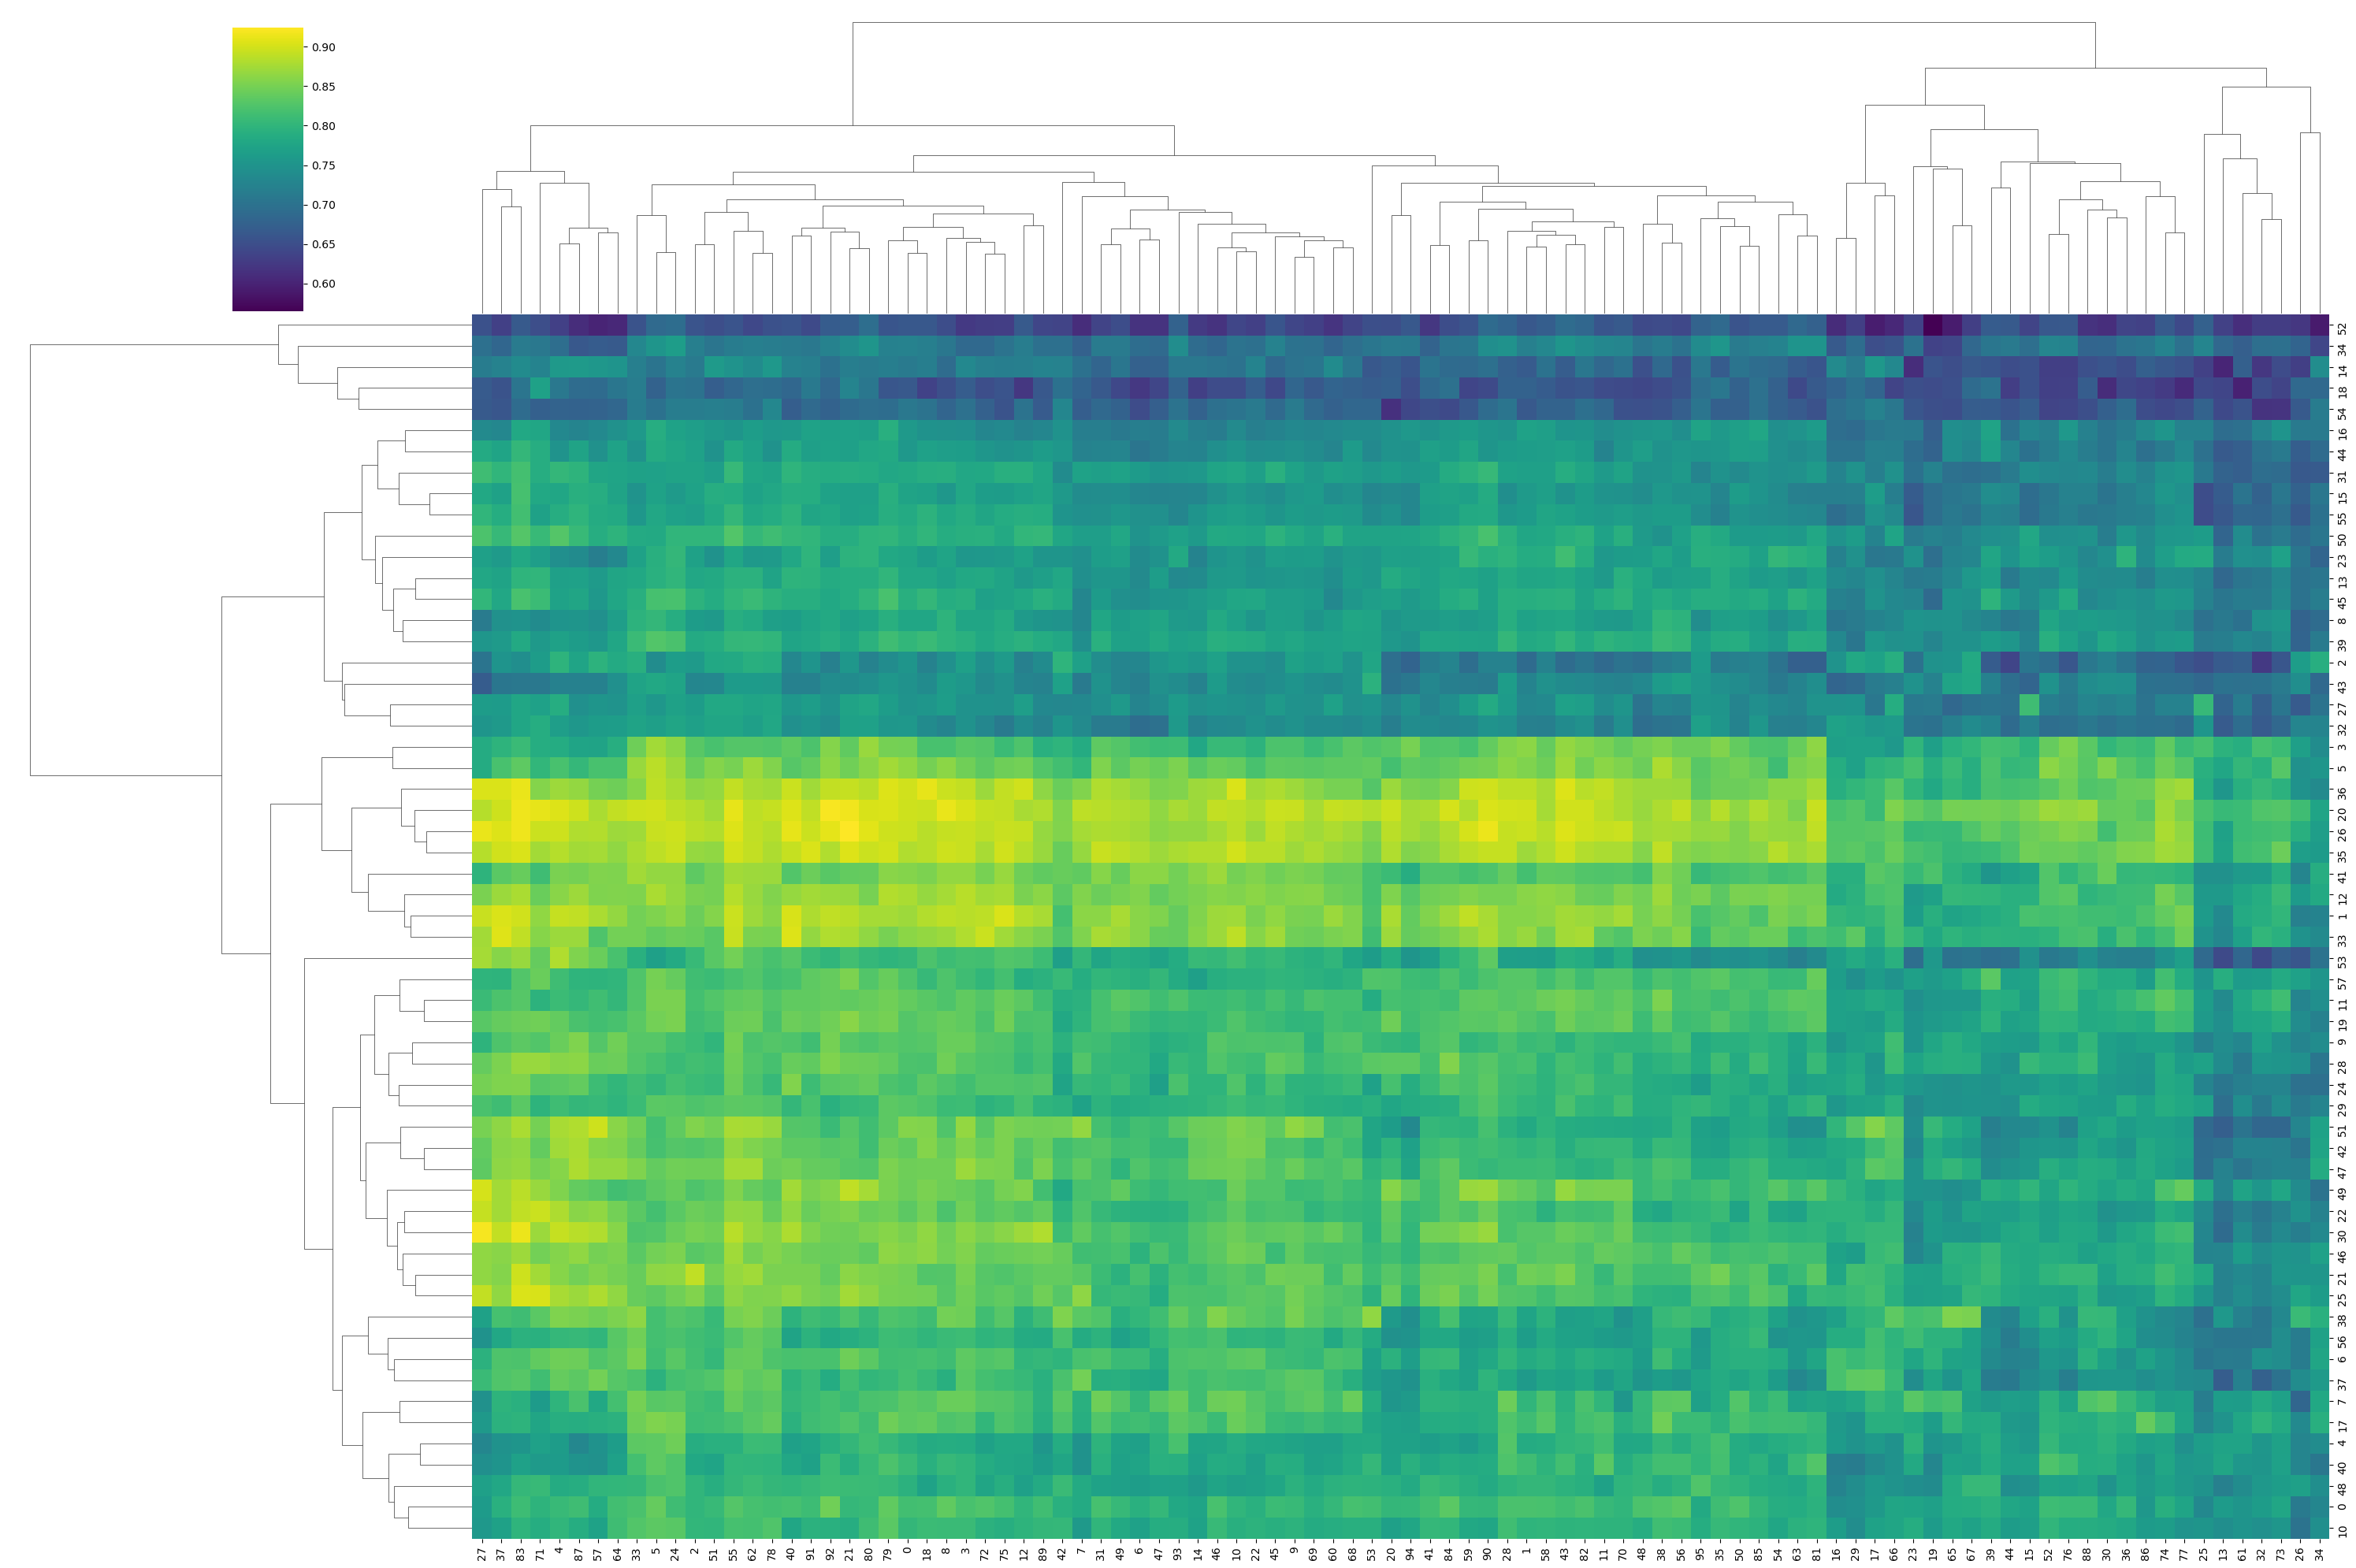

In [56]:
clustermap = sns.clustermap(
    distances_df,
    cmap='viridis',
    figsize=(30, 20),  # Set the figure size here
    dendrogram_ratio=(0.2, 0.2),  # Adjust the dendrogram ratio if needed
    cbar_pos=(0.1, 0.8, 0.03, 0.18)  # Adjust the color bar position if needed
)

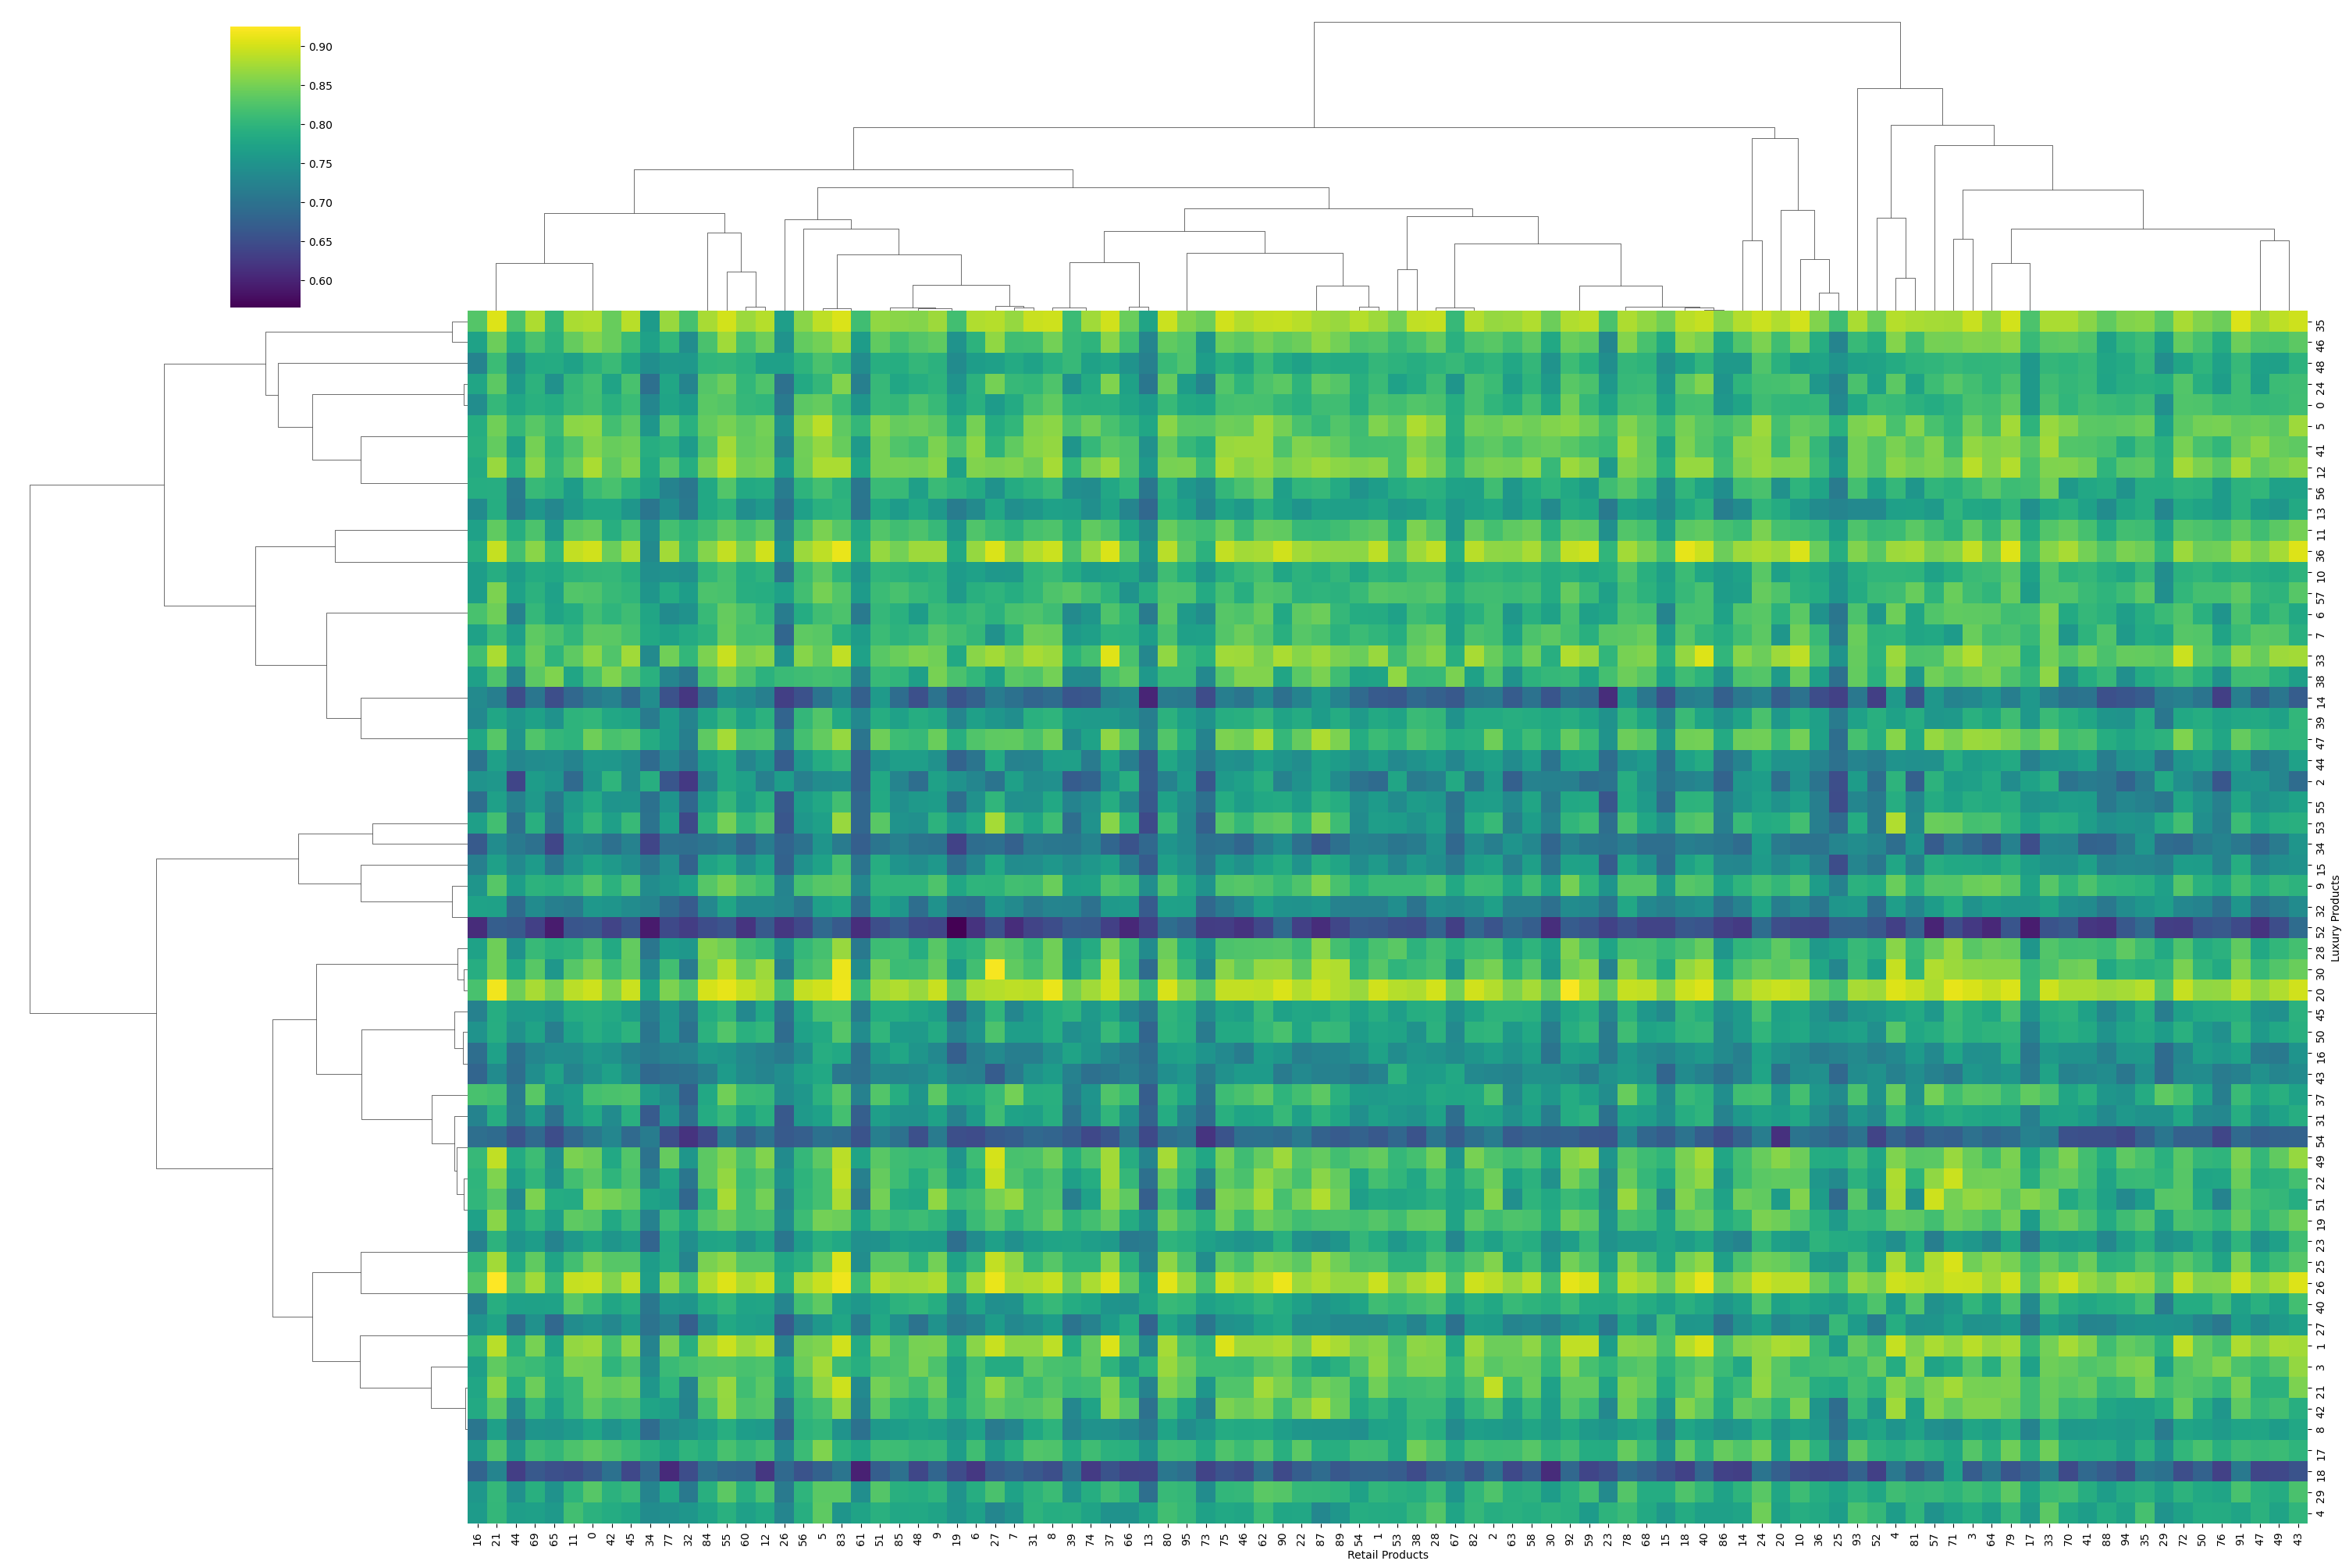

In [57]:
# Reorder the cosine distance dataframe
ordered_cosine = distances_df.loc[luxury_order, retail_order]

# Plot the hierarchical clustering heatmap with adjusted figure size
clustermap = sns.clustermap(
    ordered_cosine,
    row_linkage=luxury_linkage,
    col_linkage=retail_linkage,
    cmap='viridis',
    figsize=(30, 20),  # Set the figure size here
    dendrogram_ratio=(0.2, 0.2),  # Adjust the dendrogram ratio if needed
    cbar_pos=(0.1, 0.8, 0.03, 0.18)  # Adjust the color bar position if needed
)

# Add axis labels
clustermap.ax_heatmap.set_xlabel('Retail Products')
clustermap.ax_heatmap.set_ylabel('Luxury Products')

plt.show()

In [58]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib.pyplot import figure
from scipy.cluster.hierarchy import fcluster

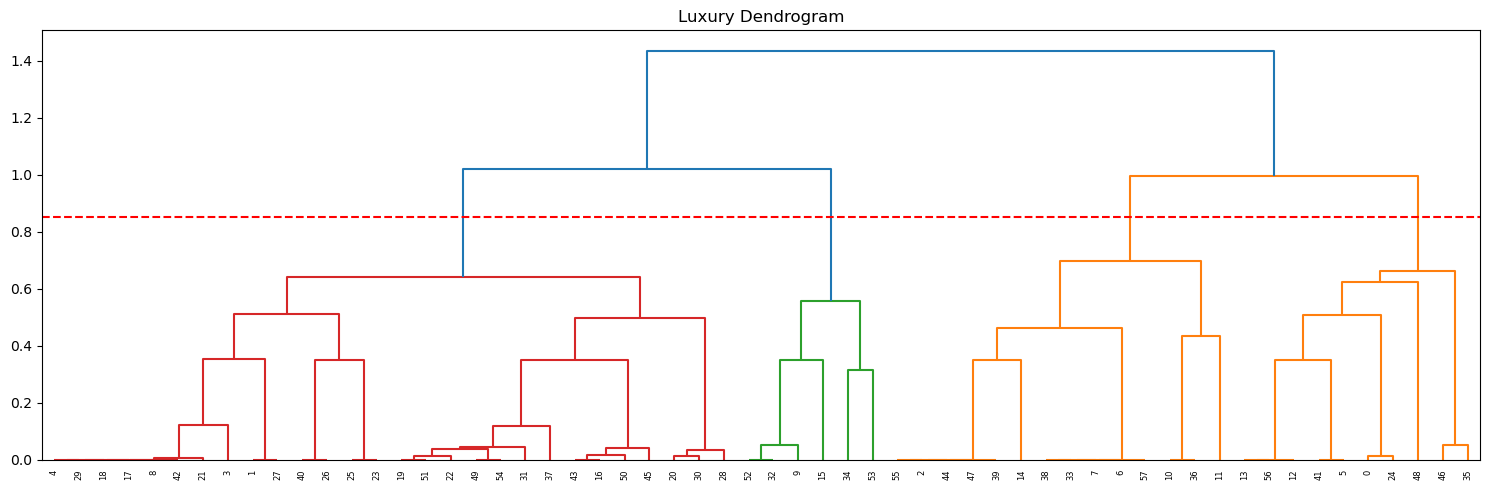

In [59]:
treshhold = 0.85

# Plot the dendrograms separately
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot dendrogram for luxury
dendrogram(luxury_linkage, labels=luxury_order, ax=ax, leaf_rotation=90)
ax.invert_xaxis()
plt.axhline(y=treshhold, color='red', linestyle='--', label=f'Height {treshhold}')
plt.title('Luxury Dendrogram')
plt.tight_layout()
plt.show()

In [60]:
luxury_clusters_brand = fcluster(luxury_linkage, treshhold, criterion='distance')

In [61]:
def adjust_cluster_df(luxury_order,luxury_clusters_brand,encoded_luxury_df , is_luxury):

    if is_luxury:
        luxury_clusters_brand = luxury_clusters_brand + 10

    clusters_indexes_luxury_brand = pd.DataFrame([luxury_order,luxury_clusters_brand])
    clusters_indexes_luxury_brand = clusters_indexes_luxury_brand.T
    clusters_indexes_luxury_brand.columns = ['position','cluster']

    clusters_indexes_luxury_brand.sort_values(by='position', inplace= True)
    clusters_indexes_luxury_brand['prod_id'] = encoded_luxury_df.prod_id

    clusters_indexes_luxury_brand.drop(labels=['position'],axis=1,inplace = True)

    return clusters_indexes_luxury_brand

In [62]:
clusters_indexes_luxury_brand = adjust_cluster_df(luxury_order = luxury_order, luxury_clusters_brand=luxury_clusters_brand, encoded_luxury_df= encoded_luxury_df, is_luxury=True )

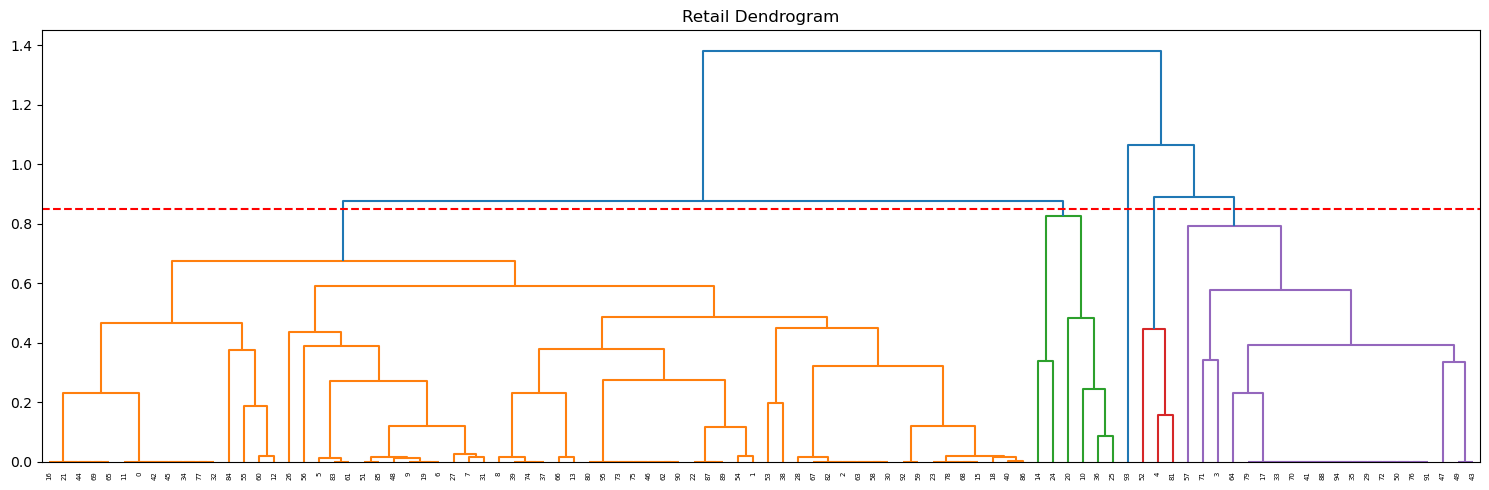

In [63]:
treshhold = 0.85

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
dendrogram(retail_linkage, labels=retail_order, ax=ax, leaf_rotation=90, color_threshold=treshhold)
plt.axhline(y=treshhold, color='red', linestyle='--', label=f'Height {treshhold}')
plt.title('Retail Dendrogram')
plt.tight_layout()
plt.show()

In [64]:
retail_clusters_brand = fcluster(retail_linkage, treshhold, criterion='distance')

In [65]:
clusters_indexes_retail_brand = adjust_cluster_df(luxury_order = retail_order, luxury_clusters_brand=retail_clusters_brand, encoded_luxury_df= encoded_retail_df, is_luxury=False )

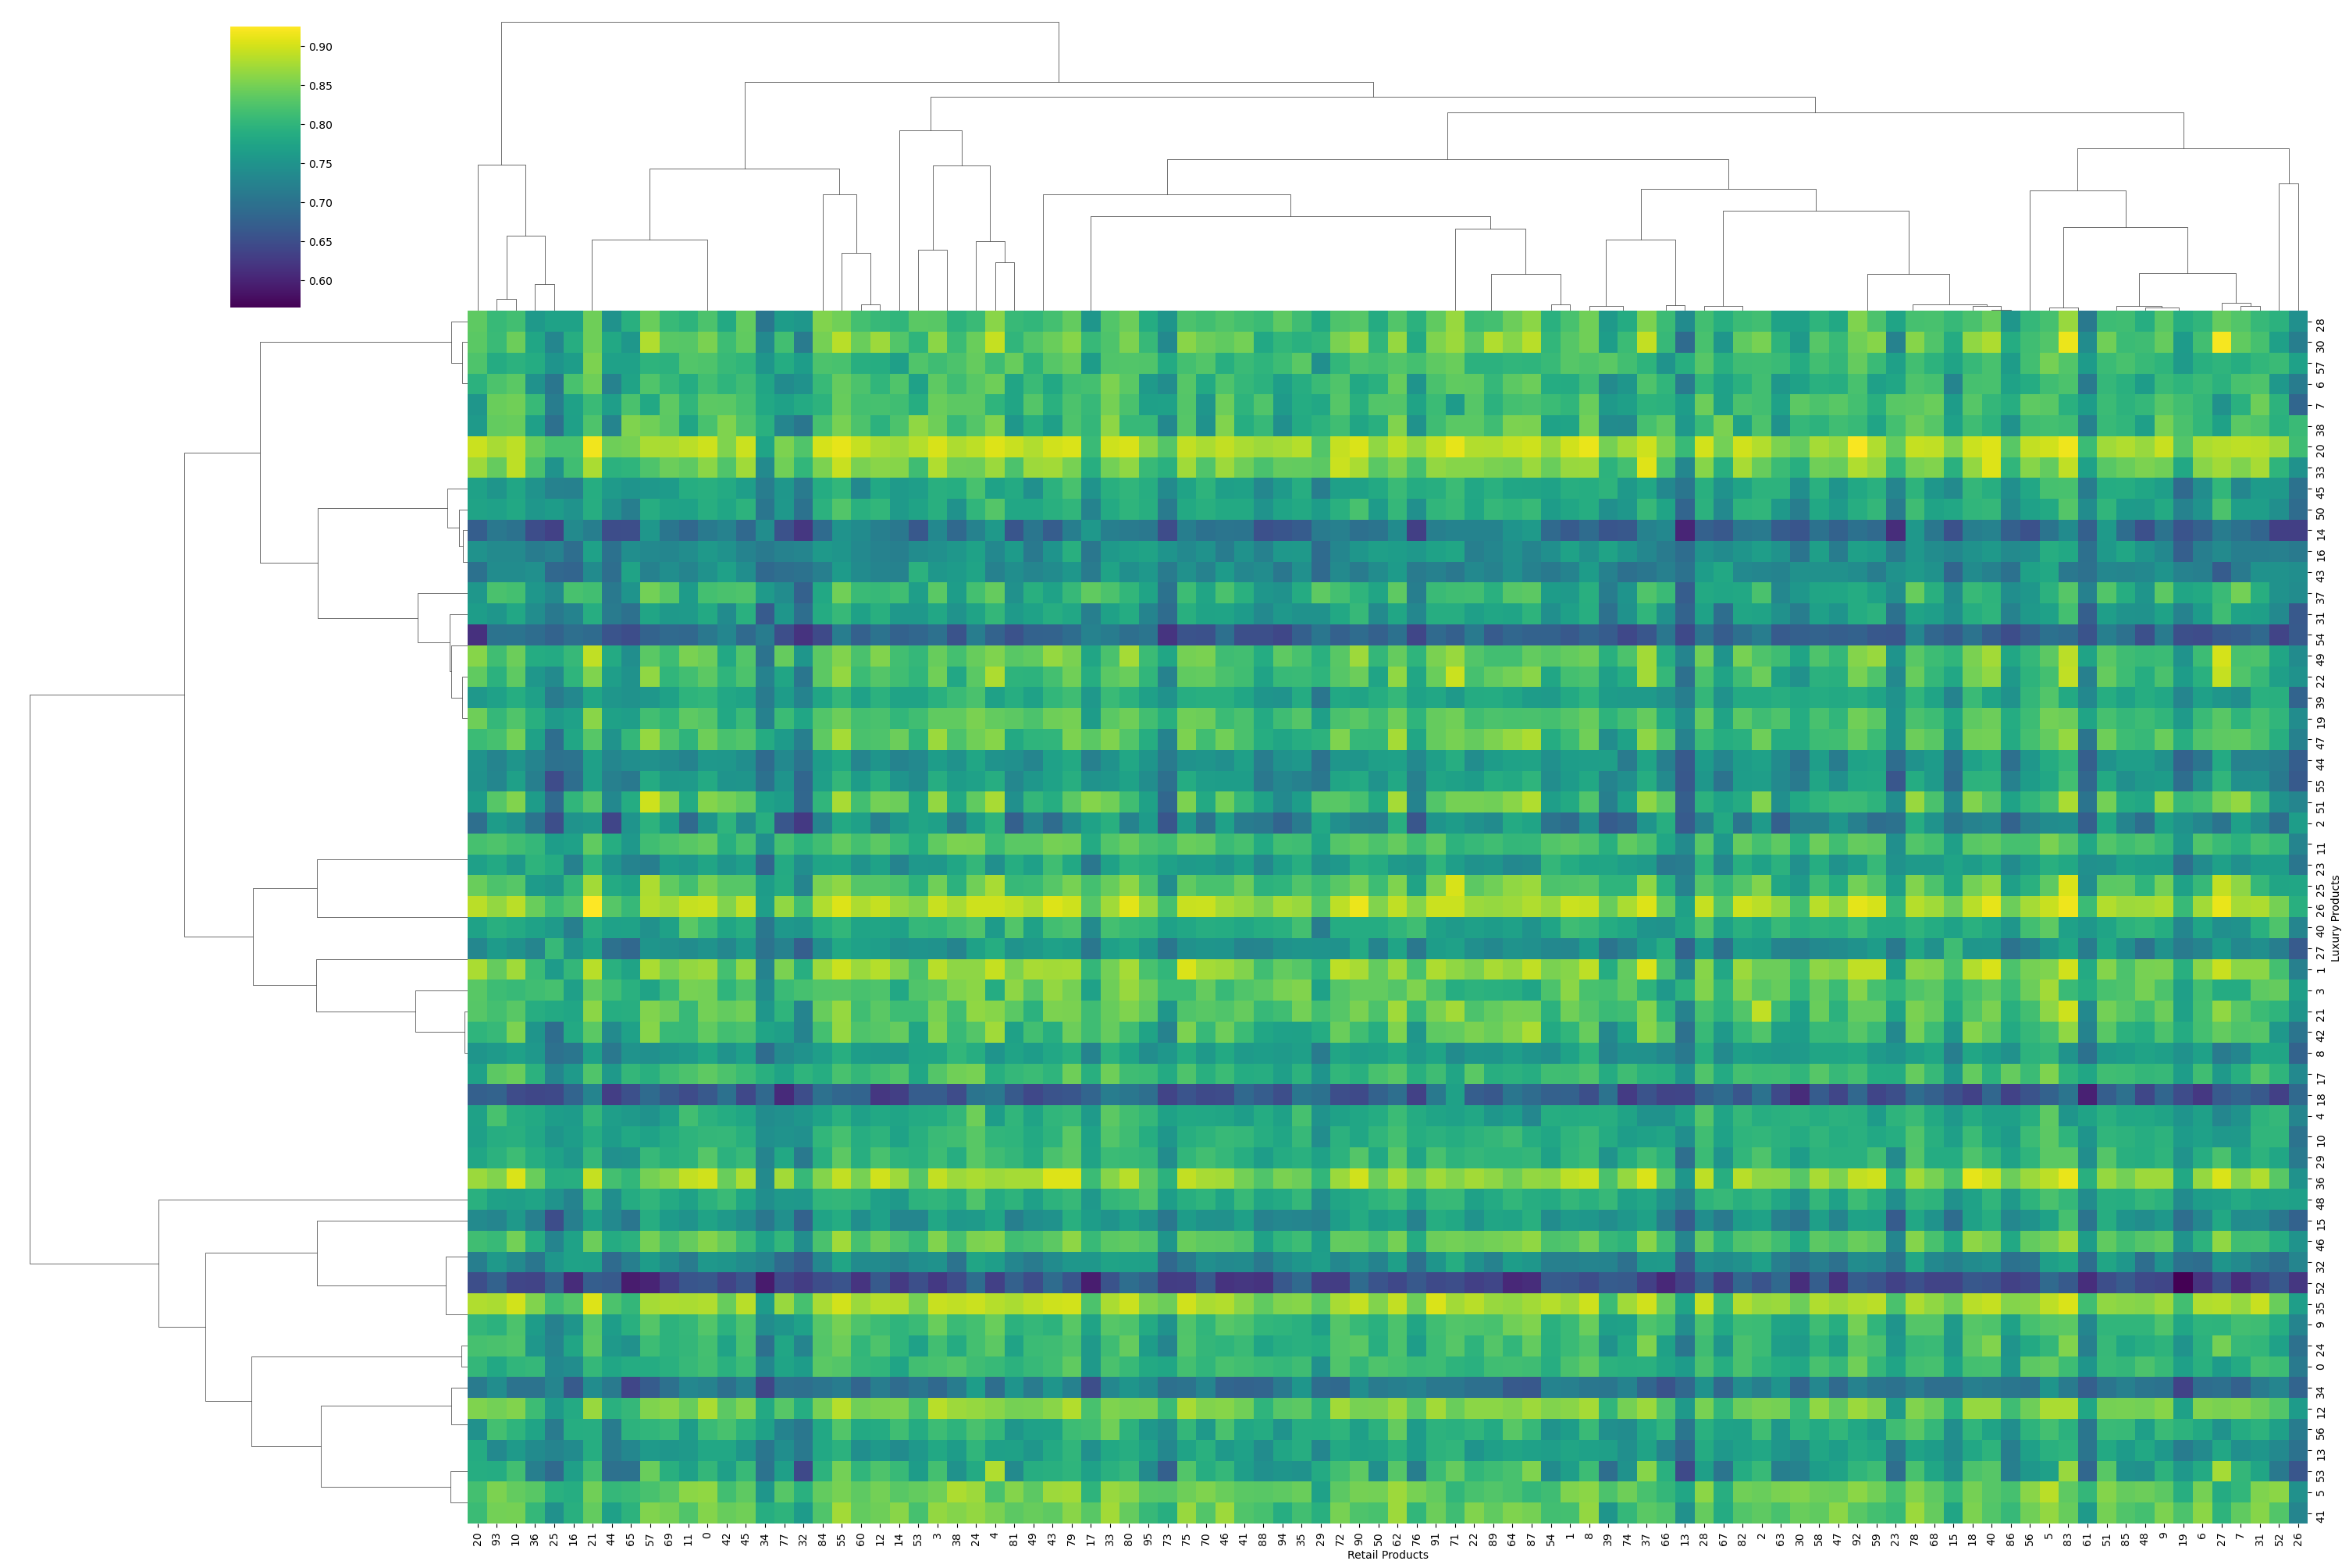

In [66]:
# Reorder the cosine distance dataframe
ordered_cosine = distances_df.loc[luxury_order, retail_order]

# Plot the hierarchical clustering heatmap with adjusted figure size
clustermap = sns.clustermap(
    ordered_cosine,
    row_linkage=luxury_linkage_no_brand,
    col_linkage=retail_linkage_no_brand,
    cmap='viridis',
    figsize=(30, 20),  # Set the figure size here
    dendrogram_ratio=(0.2, 0.2),  # Adjust the dendrogram ratio if needed
    cbar_pos=(0.1, 0.8, 0.03, 0.18)  # Adjust the color bar position if needed
)

# Add axis labels
clustermap.ax_heatmap.set_xlabel('Retail Products')
clustermap.ax_heatmap.set_ylabel('Luxury Products')

plt.show()

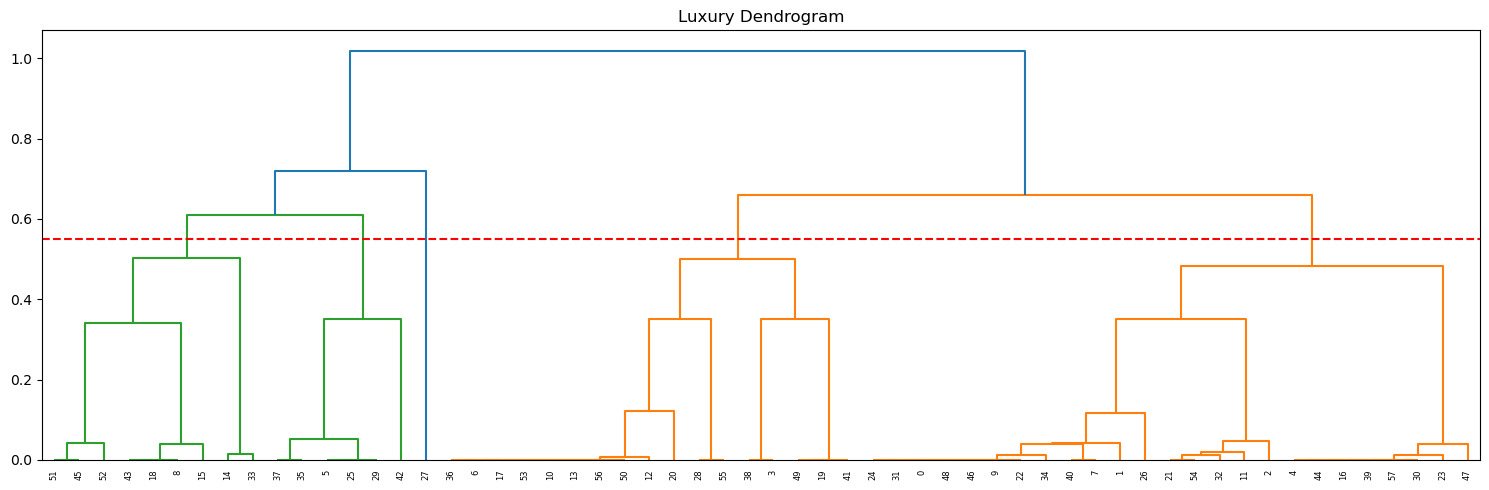

In [67]:
treshhold = 0.55

# Plot the dendrograms separately
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot dendrogram for luxury
dendrogram(luxury_linkage_no_brand, labels=luxury_order_no_brand, ax=ax, leaf_rotation=90)
ax.invert_xaxis()
plt.axhline(y=treshhold, color='red', linestyle='--', label=f'Height {treshhold}')
plt.title('Luxury Dendrogram')
plt.tight_layout()
plt.show()

In [68]:
luxury_clusters_no_brand = fcluster(luxury_linkage_no_brand, treshhold, criterion='distance')

In [69]:
clusters_indexes_luxury_no_brand = adjust_cluster_df(luxury_order = luxury_order_no_brand, luxury_clusters_brand=luxury_clusters_no_brand, encoded_luxury_df= encoded_luxury_df, is_luxury= True )

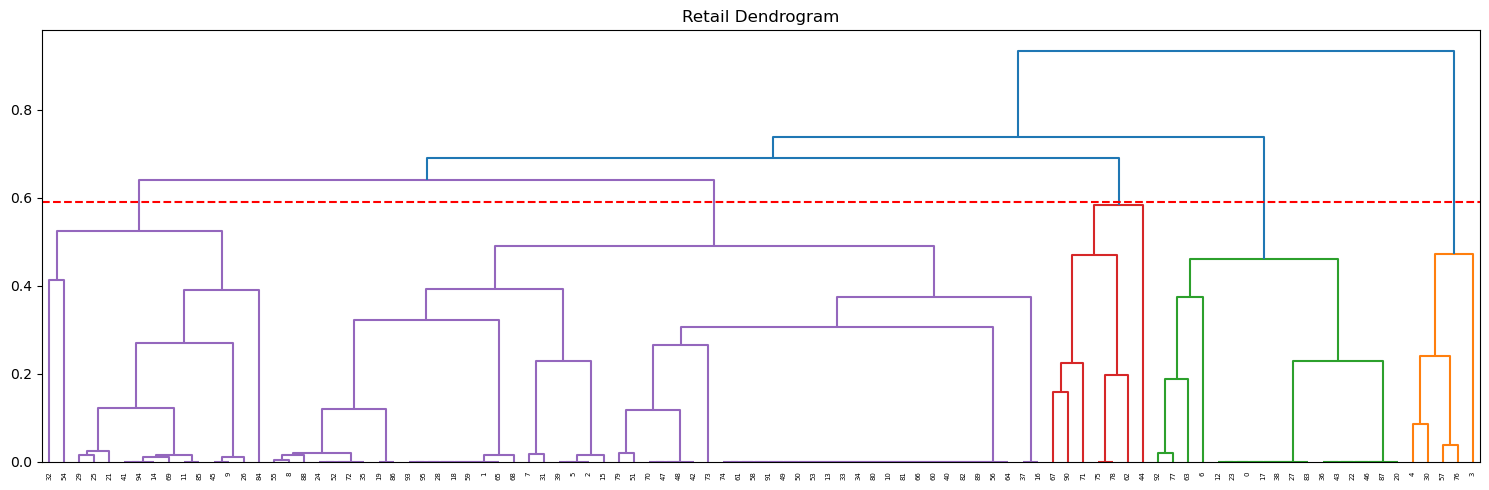

In [70]:
treshhold = 0.59

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
dendrogram(retail_linkage_no_brand, labels=retail_order_no_brand, ax=ax, leaf_rotation=90)
ax.invert_xaxis()
plt.axhline(y=treshhold, color='red', linestyle='--', label=f'Height {treshhold}')
plt.title('Retail Dendrogram')
plt.tight_layout()
plt.show()

In [71]:
retail_clusters_no_brand = fcluster(retail_linkage_no_brand, treshhold, criterion='distance')

In [72]:
clusters_indexes_retail_no_brand = adjust_cluster_df(luxury_order = retail_order_no_brand, luxury_clusters_brand=retail_clusters_no_brand, encoded_luxury_df= encoded_retail_df, is_luxury=False )

In [73]:
df_clusters_no_brand = pd.concat([clusters_indexes_retail_no_brand,clusters_indexes_luxury_no_brand]).sort_values('prod_id').reset_index(drop=True)
df_clusters_brand = pd.concat([clusters_indexes_retail_brand,clusters_indexes_luxury_brand]).sort_values('prod_id').reset_index(drop=True)

In [74]:
df_clusters_brand.head(2)

,cluster,prod_id
0,14,1
1,14,2


In [75]:
df_clusters_no_brand.head(2)

,cluster,prod_id
0,11,1
1,11,2


In [76]:
df_clusters_brand['cluster_no_brand'] = df_clusters_no_brand['cluster']

In [77]:
df_clusters_brand.columns = ['cluster_brand', 'Brand_id', 'cluster_no_brand']

In [78]:
df_clusters_brand.to_csv('clusters.csv')

#### Checking 

Luxury produc

In [79]:
import base64
from io import BytesIO
from PIL import Image

def base64_to_image(base64_string):
    # Remove the data URI prefix if present
    if "data:image" in base64_string:
        base64_string = base64_string.split(",")[1]
    # Decode the Base64 string into bytes
    image_bytes = base64.b64decode(base64_string)
    return image_bytes

def create_image_from_bytes(image_bytes):
    # Create a BytesIO object to handle the image data
    image_stream = BytesIO(image_bytes)

    # Open the image using Pillow (PIL)
    image = Image.open(image_stream)
    return image

def resize_image(image, new_width):
    # Open the image

    # Calculate the new height while maintaining the aspect ratio
    original_width, original_height = image.size
    aspect_ratio = original_height / original_width
    new_height = int(new_width * aspect_ratio)

    # Resize the image
    resized_image = image.resize((new_width, new_height))

    return resized_image

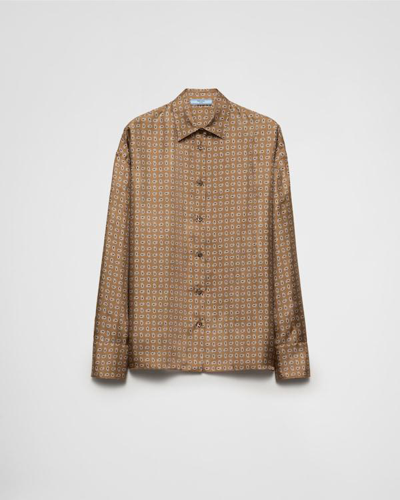

In [80]:
current_prod_id = encoded_luxury_df.iloc[20].prod_id

l = df_base64[df_base64.prod_id == current_prod_id]
i = l.index[0]
img = l['base64'][i][0]

resize_image(create_image_from_bytes(base64_to_image(img)),400)

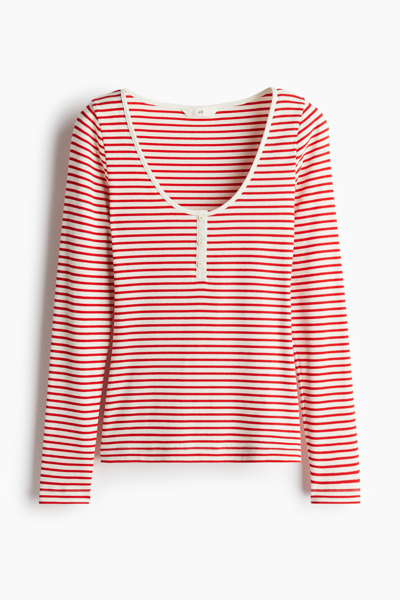

In [81]:
# 21 45 55

current_prod_id = encoded_retail_df.iloc[21].prod_id

l = df_base64[df_base64.prod_id == current_prod_id]
i = l.index[0]
img = l['base64'][i][4]

resize_image(create_image_from_bytes(base64_to_image(img)),400)

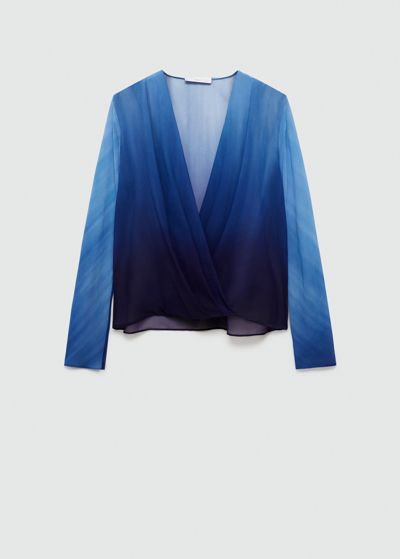

In [82]:
# 21 45 55

current_prod_id = encoded_retail_df.iloc[45].prod_id

l = df_base64[df_base64.prod_id == current_prod_id]
i = l.index[0]
img = l['base64'][i][2]

resize_image(create_image_from_bytes(base64_to_image(img)),400)

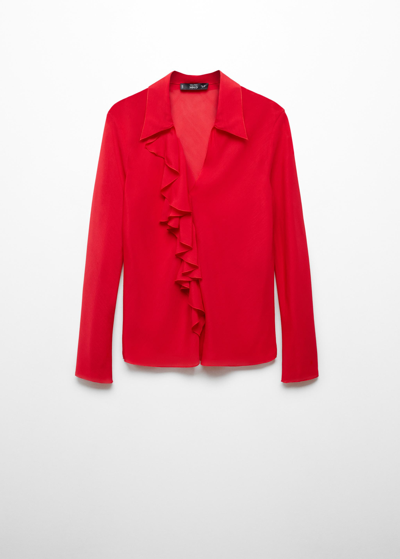

In [83]:
# 21 45 55

current_prod_id = encoded_retail_df.iloc[55].prod_id

l = df_base64[df_base64.prod_id == current_prod_id]
i = l.index[0]
img = l['base64'][i][1]

resize_image(create_image_from_bytes(base64_to_image(img)),400)